In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate

In [2]:
path = "C:/Users/Sneha Reddy/OneDrive/Documents/Lung Segmentation-20231129T011203Z-001/Lung Segmentation"

In [3]:
images = sorted(glob(os.path.join(path, "CXR_png", "*.png")))
masksl = sorted(glob(os.path.join(path, "ManualMask", "leftMask", "*.png")))
masksr = sorted(glob(os.path.join(path, "ManualMask", "rightMask", "*.png")))

In [4]:
def read_image(path):
 x = cv2.imread(path)
 x = cv2.resize(x, (512, 512))
 x = x/255.0
 x = x.astype(np.float32)
 return x

In [5]:
def read_mask(path1, path2):
 x1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
 x2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
 x = x1 + x2
 x = cv2.resize(x, (512, 512))
 x = x/np.max(x)
 x = x > 0.5
 x = x.astype(np.float32)
 x = np.expand_dims(x, axis=-1)
 return x

In [6]:
def _parse(x, y1, y2):
 x = read_image(x)
 y = read_mask(y1, y2)
 return x, y

In [7]:
def imgplot(i):
    if 0 <= i < len(images):
        xray = read_image(images[i])
        mask = read_mask(masksl[i], masksr[i])

        # Squeeze the singleton dimension if it exists
        xray = np.squeeze(xray)
        mask = np.squeeze(mask)

        fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
        axis[0].imshow(xray, cmap='gray')
        axis[1].imshow(mask, cmap='gray')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Index {i} is out of range for the 'images' list.")


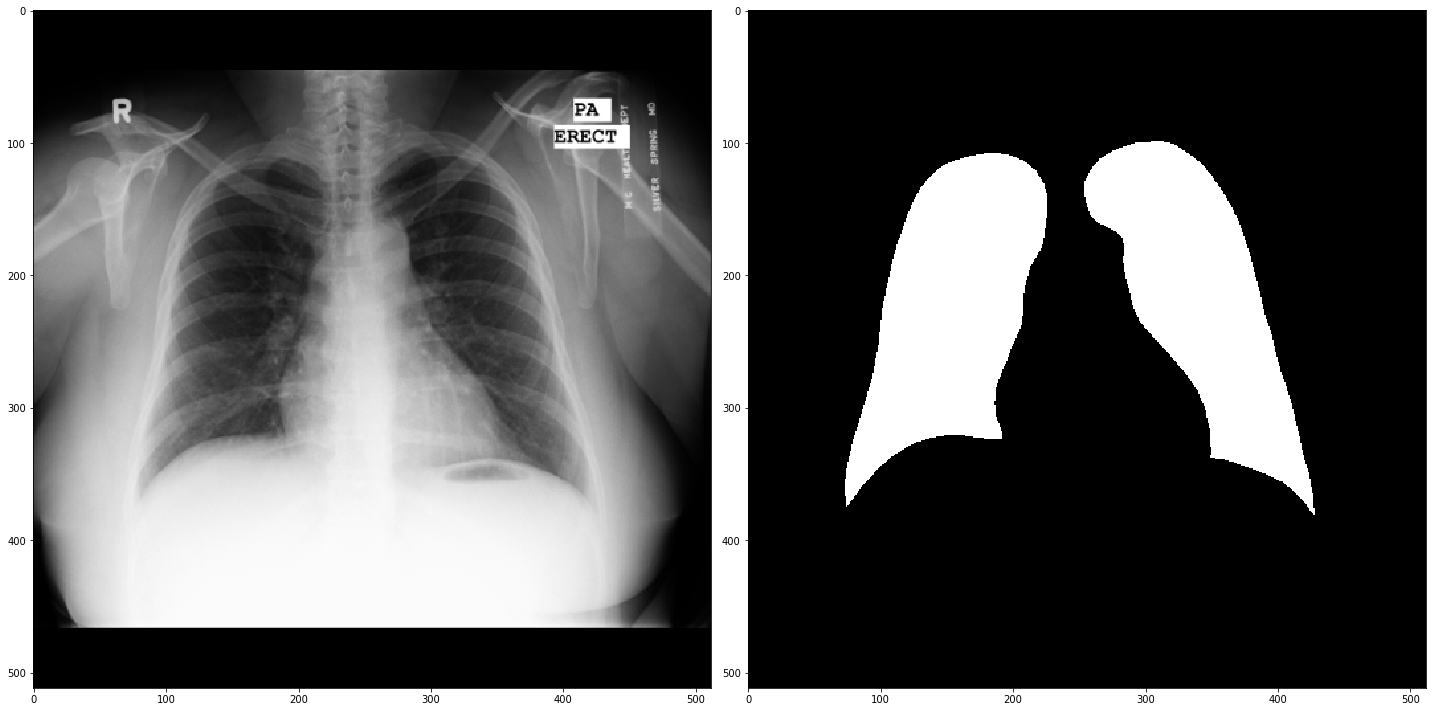

In [8]:
imgplot(1)

In [9]:
xrays = []
for i in range(len(images)):
 xrays.append(tf.expand_dims(read_image(images[i]), axis=0))

In [10]:
masks = []
for i in range(len(masksl)):
 masks.append(tf.expand_dims(read_mask(masksl[i],masksr[i]), axis=0))

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_x, test_x, train_y, test_y = train_test_split(xrays,masks, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x,train_y, test_size=0.2, random_state=42)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

In [14]:
from tensorflow.keras.layers import Input,Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Model

In [15]:
def convolution(input,channels):
 x = Conv2D(channels,3,padding='same',activation = 'relu')(input)
 x = Conv2D(channels,3,padding='same',activation = 'relu')(x)
 return x

In [16]:
def encoder(input, channels):
 x = convolution(input, channels)
 p = MaxPool2D((2,2))(x)
 return x,p

In [17]:
def decoder(input, skip_features, channels):
 x = Conv2DTranspose(channels, (2,2), strides=2, padding='same')(input)
 x = Concatenate()([x,skip_features])
 x = convolution(x, channels)
 return x

In [18]:
def unet(input_shape):
 inputs = Input(input_shape)
 
 l1, p1 = encoder(inputs, 64)
 l2, p2 = encoder(p1, 128)
 l3, p3 = encoder(p2, 256)
 l4, p4 = encoder(p3, 512)
 
 l = convolution(p4,1024)
 
 u1 = decoder(l, l4, 512)
 u2 = decoder(u1, l3, 256)
 u3 = decoder(u2, l2, 128)
 u4 = decoder(u3, l1, 64)
 
 output = Conv2D(1,1, padding = 'same', activation = "sigmoid")(u4)
 
 model = Model(inputs, output, name = "UNET")
 return model

In [19]:
model = unet((512,512,3))

In [20]:
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [21]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________________

In [22]:
callbacks = [
 ModelCheckpoint('Unet_lung_seg.hdf5', verbose=1, save_best_only=True),
 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
 ]

In [23]:
model.fit(
 train_dataset,
 epochs=10,
 validation_data=valid_dataset,
 callbacks=callbacks,
 )

Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.7945   
Epoch 00001: val_loss improved from inf to 0.32940, saving model to Unet_lung_seg.hdf5
88/88 [==============================] - 68588s 779s/step - loss: 0.4543 - accuracy: 0.7945 - val_loss: 0.3294 - val_accuracy: 0.7800
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8279 
Epoch 00002: val_loss improved from 0.32940 to 0.17944, saving model to Unet_lung_seg.hdf5
88/88 [==============================] - 1279s 15s/step - loss: 0.2819 - accuracy: 0.8279 - val_loss: 0.1794 - val_accuracy: 0.9479
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9252
Epoch 00003: val_loss improved from 0.17944 to 0.15962, saving model to Unet_lung_seg.hdf5
88/88 [==============================] - 881s 10s/step - loss: 0.1856 - accuracy: 0.9252 - val_loss: 0.1596 - val_accuracy: 0.9407
Epoch 4/10
88/88 [==============================

In [24]:
filename = "Saved_model.joblib"

In [25]:
import joblib

In [26]:
joblib.dump(model, filename)

TypeError: can't pickle _thread.RLock objects

In [ ]:
model = joblib.load(filename)

In [ ]:
def predict_plot(i):
 
 t = test_x[i]
 z = np.array(test_y[i]).reshape(512,512,1)
 y = model.predict(t)
 y = y.reshape(512,512,1)
 x = np.array(test_x[i]).reshape(512,512,3)
 
 fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
 axis[0].imshow(x, cmap='gray')
 axis[1].imshow(y, cmap='gray')
 axis[2].imshow(z, cmap='gray')
 plt.tight_layout()

In [ ]:
for i in range(10):
 predict_plot(i)

In [ ]:
test_images = []
for ext in ('*.png', '*.jpeg'):
   test_images.extend(glob(os.path.join(path, "TestCheck", ext)))

In [ ]:
test_xrays = []
for i in range(len(test_images)):
 test_xrays.append(tf.expand_dims(read_image(test_images[i]), axis=0))

In [ ]:
def test_predict_plot(i):
 
 t = test_xrays[i]
 #z = np.array(test_y[i]).reshape(512,512,1)
 y = model.predict(t)
 y = y.reshape(512,512,1)
 x = np.array(test_xrays[i]).reshape(512,512,3)
 
 fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
 axis[0].imshow(x, cmap='gray')
 axis[1].imshow(y, cmap='gray')
 #axis[2].imshow(z, cmap='gray')
 plt.tight_layout()

In [ ]:
for i in range(30):
 test_predict_plot(i)

In [ ]:
normal_images = []
for ext in ('*.png', '*.jpeg'):
   normal_images.extend(glob(os.path.join("C:/Users/Sneha Reddy/OneDrive/Documents/Final Images/Normal Images", ext)))

In [ ]:
normal_xrays = []
for i in range(len(normal_images)):
 normal_xrays.append(tf.expand_dims(read_image(normal_images[i]), axis=0))

In [ ]:
len(normal_xrays)

In [ ]:
def save_predict_plot(i):
 
 t = normal_xrays[i]
 y = model.predict(t)
 y = y.reshape(512,512,1)
 y = cv2.convertScaleAbs(y, alpha=(255.0))
 p=cv2.imwrite("C:/Users/Sneha Reddy/OneDrive/Documents/Segmented Images/Normal Images/normal_image{}.png".format(i),y)

In [ ]:
for i in range(len(normal_xrays)):
 save_predict_plot(i)

In [ ]:
from keras.models import load_model
model = load_model('Unet_lung_seg.hdf5')

In [ ]:
other_images = []
for ext in ('*.png', '*.jpeg'):
   other_images.extend(glob(os.path.join("C:/Users/Sneha Reddy/OneDrive/Documents/Final Images/Other Images", ext)))

In [ ]:
other_xrays = []
for i in range(len(other_images)):
 other_xrays.append(tf.expand_dims(read_image(other_images[i]), axis=0))

In [ ]:
len(other_xrays)

In [ ]:
def save_predict_plot(i):
 
 t = other_xrays[i]
 y = model.predict(t)
 y = y.reshape(512,512,1)
 y = cv2.convertScaleAbs(y, alpha=(255.0))
 p=cv2.imwrite("C:/Users/Sneha Reddy/OneDrive/Documents/Segmented Images/Other Images/other_image{}.png".format(i),y)

In [ ]:
for i in range(len(other_xrays)):
 save_predict_plot(i)

In [ ]:
pneumonia_images = []
for ext in ('*.png', '*.jpeg'):
   pneumonia_images.extend(glob(os.path.join("C:/Users/Sneha Reddy/OneDrive/Documents/Final Images/
                                             
                                             Pneumonia Images", ext)))

In [ ]:
pneumonia_xrays = []
for i in range(len(pneumonia_images)):
 pneumonia_xrays.append(tf.expand_dims(read_image(pneumonia_images[i]), axis=0))

In [ ]:
len(pneumonia_xrays)

In [ ]:
def save_predict_plot(i):
 
 t = pneumonia_xrays[i]
 y = model.predict(t)
 y = y.reshape(512,512,1)
 y = cv2.convertScaleAbs(y, alpha=(255.0))
 p=cv2.imwrite("C:/Users/Sneha Reddy/OneDrive/Documents/Segmented Images/Pneumonia Images/pneumonia_image{}.png".format(i),y)

In [ ]:
for i in range(len(pneumonia_xrays)):
 save_predict_plot(i)